In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

In [2]:
FILE = 'globalterrorismdb_0718dist.csv'
raw_df = pd.read_csv(FILE, index_col='eventid', encoding='ISO-8859-1')

C:\Users\Abe-r\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns', None)
raw_df.head(5)

,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
eventid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,

#### Examine the data
Eyeballing the data, here are some of the less obvious but useful columns

* success
* attacktypes
* targettypes
* targetsubtypes
* nationality of target ?
* weapontypes
* related?

**NOTE** Mention in the report that data such as kills are removed since the objective is to just relate terrorist attacks to several factors. Some terrorist attacks that target individuals only exist but it might be too little to consider.

In [4]:
# Get mappings for numeric columns with text equivalent
def extract_mapping(df, numeric, text):
    _tmp = raw_df[[numeric, text]]
    _tmp = _tmp.drop_duplicates()
    return {r[numeric]: r[text] for i, r in _tmp.iterrows()}

country_mappings = extract_mapping(raw_df, 'country', 'country_txt')
region_mappings = extract_mapping(raw_df, 'region', 'region_txt')
attack_type_mappings = extract_mapping(raw_df, 'attacktype1', 'attacktype1_txt')
target_type_mappings = extract_mapping(raw_df, 'targtype1', 'targtype1_txt')
target_sub_type_mappings = extract_mapping(raw_df, 'targsubtype1', 'targsubtype1_txt')
nationality_target_mappings = extract_mapping(raw_df, 'natlty1', 'natlty1_txt')
weapon_type_mappings = extract_mapping(raw_df, 'weaptype1', 'weaptype1_txt')

In [6]:
minified_cols = ['iyear', 'imonth', 'iday', 'extended', 
                'country', 'region', 'success', 'attacktype1', 'targtype1',
               'natlty1', 'weaptype1']
minified_df = raw_df[minified_cols]

minified_df.head(2)

,iyear,imonth,iday,extended,country,region,success,attacktype1,targtype1,natlty1,weaptype1
eventid,,,,,,,,,,,
197000000001,1970,7,2,0,58,2,1,1,14,58.0,13
197000000002,1970,0,0,0,130,1,1,6,7,21.0,13


In [7]:
grouped_by_year = minified_df.groupby(['iyear', 'country']).size().to_frame('number_of_attacks').reset_index()
grouped_by_month = minified_df.groupby(['iyear', 'imonth', 'country']).size().to_frame('number_of_attacks').reset_index()

In [8]:
# mean number of attack is 46
def label_attack(r):
    if r['number_of_attacks'] < 20:
        return 'few'
    elif r['number_of_attacks'] < 40:
        return 'minimal'
    elif r['number_of_attacks'] < 60:
        return 'average'
    else:
        return 'many'

grouped_by_month['attack_category'] = grouped_by_month.apply (label_attack, axis=1)
grouped_by_year['attack_category'] = grouped_by_year.apply (label_attack, axis=1)

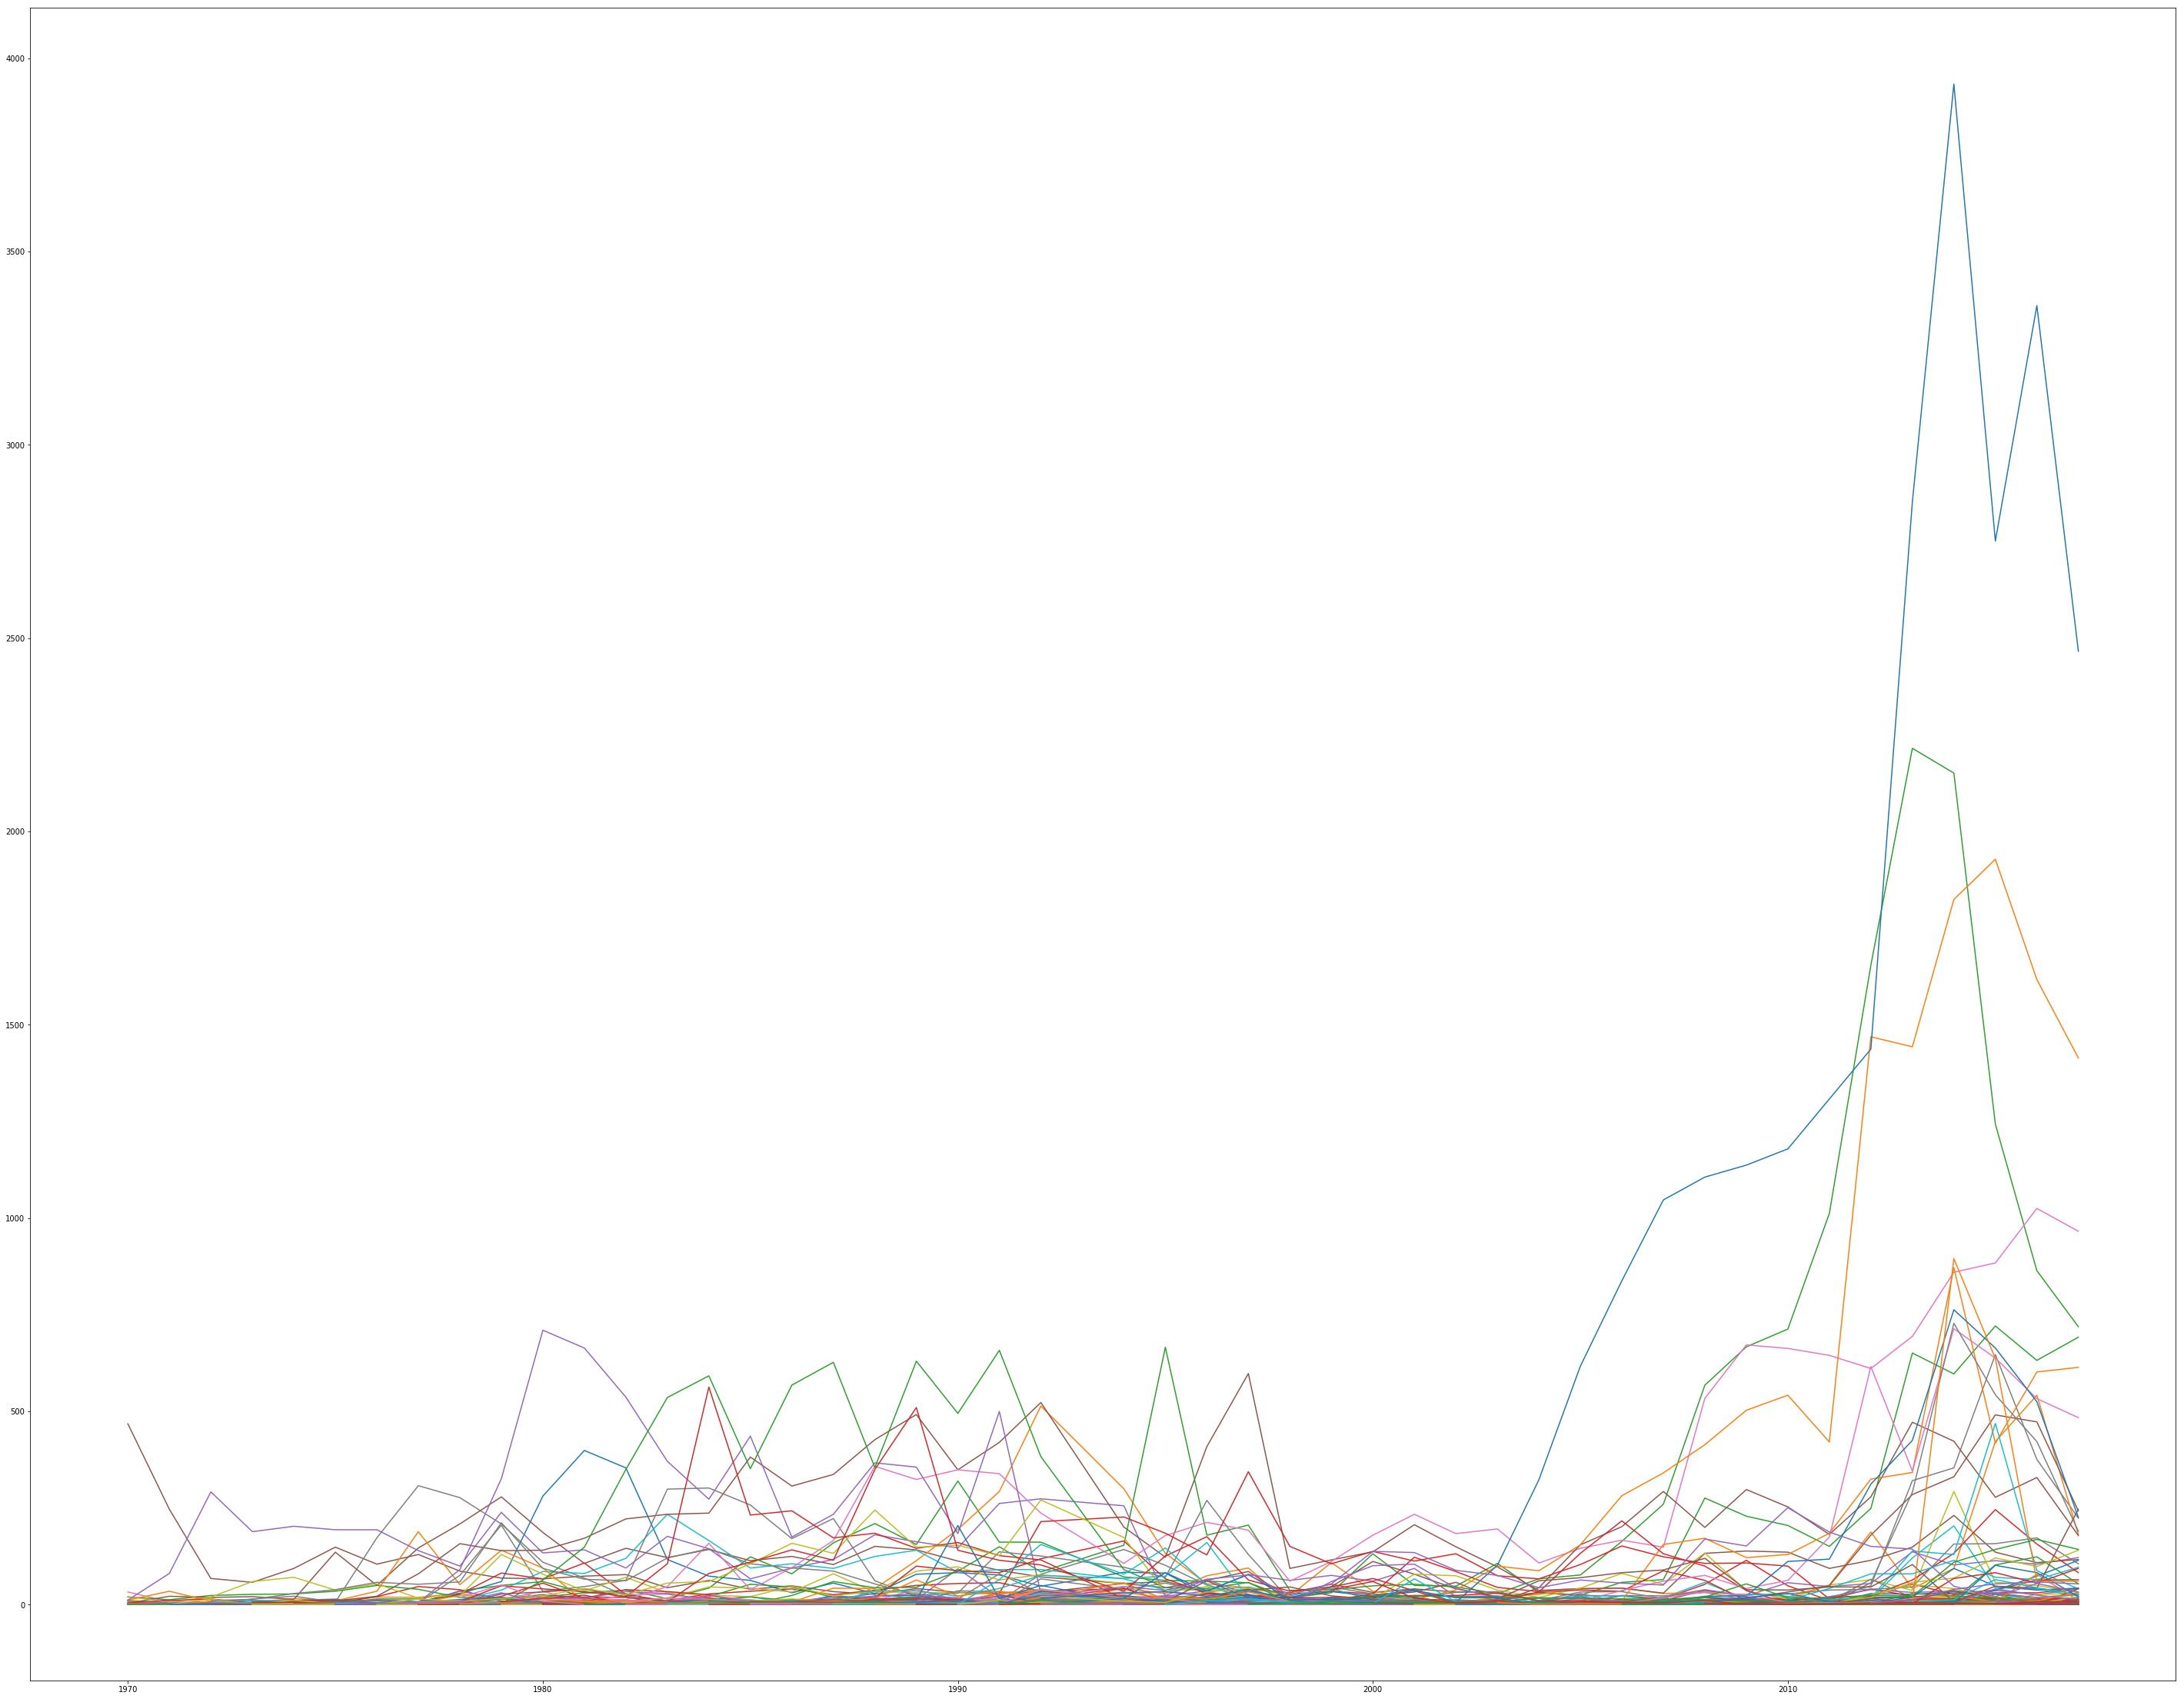

In [13]:
plt.figure(figsize=(50,40))
for _c in country_mappings:
    x = grouped_by_year[grouped_by_year.country == _c].iyear
    y = grouped_by_year[grouped_by_year.country == _c].number_of_attacks
    plt.plot(x,y)
    # print(grouped_by_year[grouped_by_year.country == _c].iyear)

plt.show()

In [14]:
grouped_by_year

,iyear,country,number_of_attacks,attack_category
0,1970,11,21,minimal
1,1970,14,1,few
2,1970,21,1,few
3,1970,26,1,few
4,1970,30,6,few
5,1970,38,2,few
6,1970,45,1,few
7,1970,58,2,few
8,1970,60,1,few
9,1970,65,3,few


In [15]:
country_mappings

{4: 'Afghanistan',
 5: 'Albania',
 6: 'Algeria',
 7: 'Andorra',
 8: 'Angola',
 10: 'Antigua and Barbuda',
 11: 'Argentina',
 12: 'Armenia',
 14: 'Australia',
 15: 'Austria',
 16: 'Azerbaijan',
 17: 'Bahamas',
 18: 'Bahrain',
 19: 'Bangladesh',
 20: 'Barbados',
 21: 'Belgium',
 22: 'Belize',
 23: 'Benin',
 25: 'Bhutan',
 26: 'Bolivia',
 28: 'Bosnia-Herzegovina',
 29: 'Botswana',
 30: 'Brazil',
 31: 'Brunei',
 32: 'Bulgaria',
 33: 'Burkina Faso',
 34: 'Burundi',
 35: 'Belarus',
 36: 'Cambodia',
 37: 'Cameroon',
 38: 'Canada',
 41: 'Central African Republic',
 42: 'Chad',
 43: 'Chile',
 44: 'China',
 45: 'Colombia',
 46: 'Comoros',
 47: 'Republic of the Congo',
 49: 'Costa Rica',
 50: 'Croatia',
 51: 'Cuba',
 53: 'Cyprus',
 54: 'Czech Republic',
 55: 'Denmark',
 56: 'Djibouti',
 57: 'Dominica',
 58: 'Dominican Republic',
 59: 'Ecuador',
 60: 'Egypt',
 61: 'El Salvador',
 62: 'Equatorial Guinea',
 63: 'Eritrea',
 64: 'Estonia',
 65: 'Ethiopia',
 66: 'Falkland Islands',
 67: 'Fiji',
 68: 'F